I have used pandas,opencv,matplotib,seaborn and Keras with theano backed to Image classification Problem

# Import Required Package

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using Theano backend.


# Process Image to extract feature and labels

In [2]:
def process_image_test(directory):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
            counter = 0
            for file_name in files:
                counter +=1
                file_path = os.path.join(root, file_name)
                images.append(file_path)
                labels.append(file_path.split('/')[2])
    return images,labels

In [3]:
train_image_geo,train_image_label = process_image_test('Data/Train')

In [4]:
test_image_geo,test_image_label = process_image_test('Data/Test')

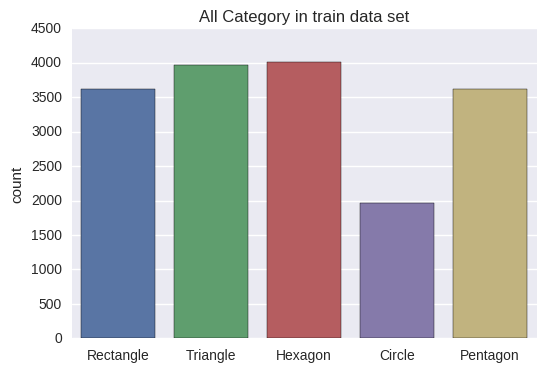

In [5]:
sns.countplot(train_image_label)
sns.plt.title('All Category in train data set')

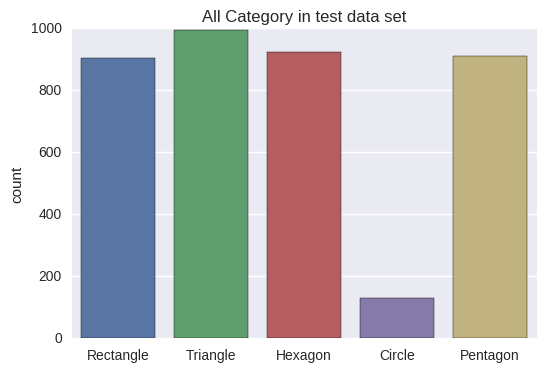

In [6]:
sns.countplot(test_image_label)
sns.plt.title('All Category in test data set')

In [13]:
ROWS = 28
COLS = 28
CHANNELS = 3
def resize_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

# Process Image in batch

In [14]:
 def convert_image_to_array(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = resize_image(image_file)
        data[i] = image.T
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [15]:
train_image = convert_image_to_array(train_image_geo)
test_image = convert_image_to_array(test_image_geo)

Processed 0 of 17168
Processed 1000 of 17168
Processed 2000 of 17168
Processed 3000 of 17168
Processed 4000 of 17168
Processed 5000 of 17168
Processed 6000 of 17168
Processed 7000 of 17168
Processed 8000 of 17168
Processed 9000 of 17168
Processed 10000 of 17168
Processed 11000 of 17168
Processed 12000 of 17168
Processed 13000 of 17168
Processed 14000 of 17168
Processed 15000 of 17168
Processed 16000 of 17168
Processed 17000 of 17168
Processed 0 of 3857
Processed 1000 of 3857
Processed 2000 of 3857
Processed 3000 of 3857


print("Train shape: {}".format(train_image.shape))
print("Test shape: {}".format(test_image.shape))

# Format Label string  to numeric category

In [9]:
train_label_df = pd.DataFrame({'Label':train_image_label},columns=['Label'])
train_label_df['Label_numeric'] = train_label_df.Label.map({"Circle":0,"Hexagon":2,"Pentagon":3,"Rectangle":1,"Triangle":5})

train_label = [str(i) for i in train_label_df['Label_numeric']]

In [ ]:
test_label_df = pd.DataFrame({'Label':test_image_label},columns=['Label'])
test_label_df['Label_numeric'] = test_label_df.Label.map({"Circle":0,"Hexagon":2,"Pentagon":3,"Rectangle":1,"Triangle":5})

test_label = [str(i) for i in test_label_df['Label_numeric']]

In [ ]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'
def getClassifications():
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model
model = getClassifications()

In [ ]:
def get_predictions_score():  
    model.fit(train_image, train_label, validation_data=(test_image, test_label), 
              nb_epoch=10, batch_size=200, verbose=2)
    scores = model.evaluate(test_image, test_label, verbose=0)
    return scores

predictions = get_predictions_score()